In [4]:
from ted_talks.scraper import TEDScraper
import pandas as pd
import numpy as np
import random
import csv
import os
from IPython.display import clear_output
import time


# обьект для работы с тедом
ts = TEDScraper(lang="en")

# Получаем ссылки на все видосы

In [2]:
all_talk_links = ts.get_all_talk_links()

Задержка на страницу: 4
[ FIND ] Now page: 2
         https://www.ted.com/talks?page=2
[ FIND ] Now page: 3
         https://www.ted.com/talks?page=3
[ FIND ] Now page: 4
         https://www.ted.com/talks?page=4
[ FIND ] Now page: 5
         https://www.ted.com/talks?page=5
[ FIND ] Now page: 6
         https://www.ted.com/talks?page=6
[ FIND ] Now page: 7
         https://www.ted.com/talks?page=7
[ FIND ] Now page: 8
         https://www.ted.com/talks?page=8
[ FIND ] Now page: 9
         https://www.ted.com/talks?page=9
[ FIND ] Now page: 10
         https://www.ted.com/talks?page=10
[ FIND ] Now page: 11
         https://www.ted.com/talks?page=11
[ FIND ] Now page: 12
         https://www.ted.com/talks?page=12
[ FIND ] Now page: 13
         https://www.ted.com/talks?page=13
[ FIND ] Now page: 14
         https://www.ted.com/talks?page=14
[ FIND ] Now page: 15
         https://www.ted.com/talks?page=15
[ FIND ] Now page: 16
         https://www.ted.com/talks?page=16
[ FIND ] Now page

[ FIND ] Now page: 128
         https://www.ted.com/talks?page=128
[ FIND ] Now page: 129
         https://www.ted.com/talks?page=129
[ FIND ] Now page: 130
         https://www.ted.com/talks?page=130
[ FIND ] Now page: 131
         https://www.ted.com/talks?page=131
[ FIND ] Now page: 132
         https://www.ted.com/talks?page=132
[ FIND ] Now page: 133
         https://www.ted.com/talks?page=133
[ FIND ] Now page: 134
         https://www.ted.com/talks?page=134
[ FIND ] Now page: 135
         https://www.ted.com/talks?page=135
[ FIND ] Now page: 136
         https://www.ted.com/talks?page=136
[ FIND ] Now page: 137
         https://www.ted.com/talks?page=137
[ FIND ] Now page: 138
         https://www.ted.com/talks?page=138
[ FIND ] Now page: 139
         https://www.ted.com/talks?page=139
[ FIND ] Now page: 140
         https://www.ted.com/talks?page=140
[ FIND ] Now page: 141
         https://www.ted.com/talks?page=141
[ FIND ] Now page: 142
         https://www.ted.com/talks?page

In [3]:
counter = 1
print("Страниц: {}".format(len(all_talk_links)))

links_file = open('talk_links.txt', 'w')

for page in all_talk_links:
    for link in page:
        links_file.write(link + '\n')
    counter+=1
        
print("Загружено")

Страниц: 153
Загружено


# Выбираем ссылки, которых нет в датасете
# И сохраняем их в файл, перемешивая

In [5]:
#counter = 152
all_talk_links = []
links_file = open('talk_links.txt', 'r')
for link in links_file:
    all_talk_links.append(link)
    

dataset = pd.read_csv("TED_Talk.csv")
dataset.head()

urls, transcripts = dataset['url__webpage'], dataset['transcript']
urlsList, transcriptsList = [], []


for i in range(0, len(urls)):
    l =  "{}\n".format(urls[i])
    if str(transcripts[i]) != 'nan':
        if l in all_talk_links:
            all_talk_links.remove(l)
        urlsList.append(urls[i])
        transcriptsList.append(transcripts[i])
    elif l not in all_talk_links:
        all_talk_links.append(l)
        
print("Ссылок в файле (для элементов без транскрипции): {}".format(len(all_talk_links)))

file = open('notAddedUrls.txt', 'w')
i = 0
for link in sorted(all_talk_links, key=lambda A: random.random()):
    file.write(str(i) + ' ' + link)
    i+=1

print("Количество элементов, для которых уже есть транскрипция: {}".format(len(urlsList)))

Ссылок в файле (для элементов без транскрипции): 1416
Количество элементов, для которых уже есть транскрипция: 4091


# Собираем датасет из данных, к которым есть транскрипт

In [6]:
def views_or_likes_to_num(string):
    if string[-1] == 'M':
        return int(float(string[0:-1]) * 1000000)
    elif string[-1] == 'K':
        return int(float(string[0:-1]) * 1000)
    else:
        return int(string[0:-1])

dataset_to_work = open('dataset_to_work.csv', 'a')
writer = csv.writer(dataset_to_work)

writer.writerow(["Title", "Date", "Views", "Likes", "Topic", "Transcript"])

count_of_bad_talks = 0

In [8]:
for i in range(0, len(urlsList)):
    try:
        other_data = ts.dump_talk_info(urls[i])
    except BaseException:
        count_of_bad_talks+=1
        continue
    
    for topic in other_data["talk_topics"]:
        row = [
            other_data["talk_title"],
            other_data["posted_date"][-4:],
            views_or_likes_to_num(other_data["views"]),
            views_or_likes_to_num(other_data["likes"]),
            topic,
            transcriptsList[i]
        ]
        writer.writerow(row)
    clear_output()
    print("Прогресс: {}%".format(i * 100.0 / len(urlsList)))
    time.sleep(1.5)


Прогресс: 0.12221950623319482%


KeyboardInterrupt: 

# Добавляем данные, полученные ручками, в датасет

In [12]:
not_added_file = open("notAddedUrls.txt", 'r')
num_to_url = dict()
for row in not_added_file:
    s = row.split()
    num_to_url[s[0]] = s[1]

dirname = './teds_by_hands'
files_names = os.listdir(dirname)

i = 0
for file_name in files_names[239:]:
    cur_file = open('./teds_by_hands/{}'.format(file_name), 'r')
    transcript = ' '.join([line for line in cur_file])
    url = num_to_url[file_name[0:-4]]
    
    try:
        other_data = ts.dump_talk_info(url)
    except BaseException:
        count_of_bad_talks+=1
        continue
    
    for topic in other_data["talk_topics"]:
        row = [
            other_data["talk_title"],
            other_data["posted_date"][-4:],
            views_or_likes_to_num(other_data["views"]),
            views_or_likes_to_num(other_data["likes"]),
            topic,
            transcript
        ]
        writer.writerow(row)
    clear_output()
    print("Прогресс: {}%".format(i * 100.0 / len(files_names)))
    i+=1
    time.sleep(1.5)
    
    
print("Количество страниц, которые не запарсились в сумме: {}".format(count_of_bad_talks))    

Прогресс: 68.1159420289855%
Количество страниц, которые не запарсились в сумме: 30


# Загружаем данные

In [15]:
dataframe = pd.read_csv("dataset_to_work.csv")
dataframe = dataframe[0:-1]

min_year, max_year = 2012, 2021


dataframe['Date'] = dataframe['Date'].astype(int)
dataframe = dataframe.loc[dataframe['Date'] >= min_year]
dataframe = dataframe.loc[dataframe['Date'] <= max_year]

print(dataframe.size)

161442


# Количество видео, просмотров, лайков в каждой темой по годам

### Топ 20 тем по количеству видео

In [16]:
all_topics = dataframe['Topic'].value_counts().to_dict()
for them in all_topics:
    print(them, all_topics[them])

science 811
TED-Ed 707
technology 702
animation 628
society 612
social change 547
education 502
TEDx 482
history 436
culture 422
health 421
humanity 410
innovation 394
communication 350
business 330
biology 327
future 321
global issues 314
community 311
design 295
personal growth 266
activism 263
creativity 261
art 260
climate change 244
nature 233
medicine 231
environment 228
TED Fellows 222
brain 215
human body 213
identity 213
health care 210
collaboration 203
economics 201
sustainability 193
psychology 187
work 186
equality 184
government 183
public health 176
medical research 175
animals 174
politics 171
women 170
engineering 164
kids 162
invention 161
performance 161
data 153
entertainment 151
music 150
disease 148
leadership 148
Internet 142
computers 139
United States 134
math 129
storytelling 129
Africa 127
space 123
race 116
family 115
war 111
gender 110
mental health 110
neuroscience 108
writing 108
illness 102
policy 101
cities 99
ocean 99
physics 98
food 96
potential 96
re

In [17]:
all_date = dataframe['Date'].value_counts().to_dict()
for them in all_date:
    print(them, all_date[them])

2016 3904
2019 3726
2017 3708
2018 3015
2015 2779
2020 2440
2012 2147
2013 1976
2014 1779
2021 1433


### Отбираем первые 20 тем

In [20]:
import matplotlib.pyplot as plt
        
topics = ['education', 'social change', 'culture', 'history', 'health', 'innovation', 'humanity', 
          'global issues', 'business', 'biology', 'communication', 'design', 'future', 'community', 
          'art', 'activism', 'creativity', 'climate change', 'environment', 'personal growth']    

    
def get_data(topics):
    views, likes, videos = dict(), dict(), dict()
    for topic in topics:
        df_filtr_by_topic = dataframe.loc[dataframe['Topic'] == topic] 
        views[topic] = np.empty(10, dtype=int)
        likes[topic] = np.empty(10, dtype=int)
        videos[topic] = np.empty(10, dtype=int)
        for year in range(2012, 2022):
            df_filtr_by_year = df_filtr_by_topic.loc[df_filtr_by_topic['Date'] == year]
            views[topic][year - 2012] = df_filtr_by_year['Views'].sum()
            likes[topic][year - 2012] = df_filtr_by_year['Likes'].sum()
            videos[topic][year - 2012] = df_filtr_by_year.size
            
    return [videos, views, likes]


videos, views, likes = get_data(topics)


### Количество видео по 20 темам

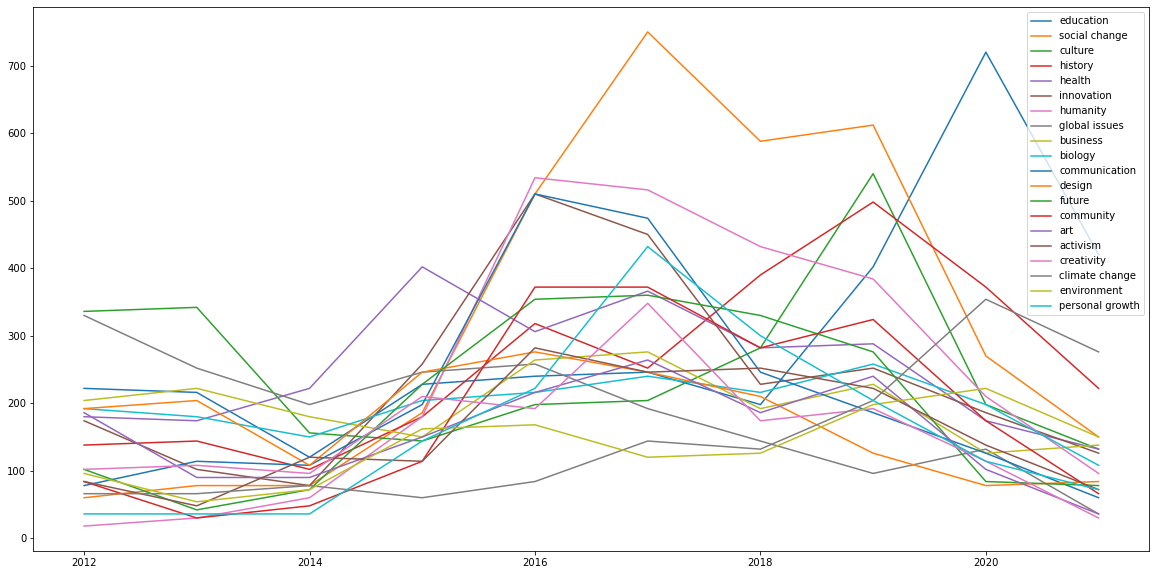

In [21]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

x = [i for i in range(2012, 2022)]
for topic in videos:
    plt.plot(x, list(videos[topic]), label = topic)

plt.legend()
plt.show()


### Количество просмотров по 20 темам

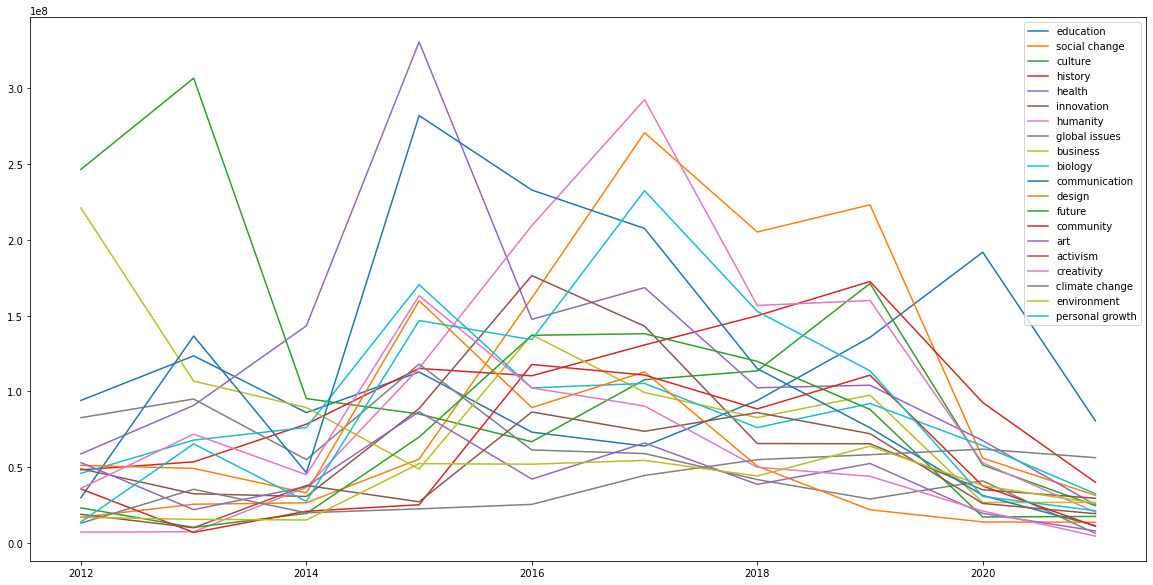

In [22]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

x = [i for i in range(2012, 2022)]
for topic in views:
    plt.plot(x, list(views[topic]), label = topic)

plt.legend()
plt.show()

### Количество лайков по 20 темам

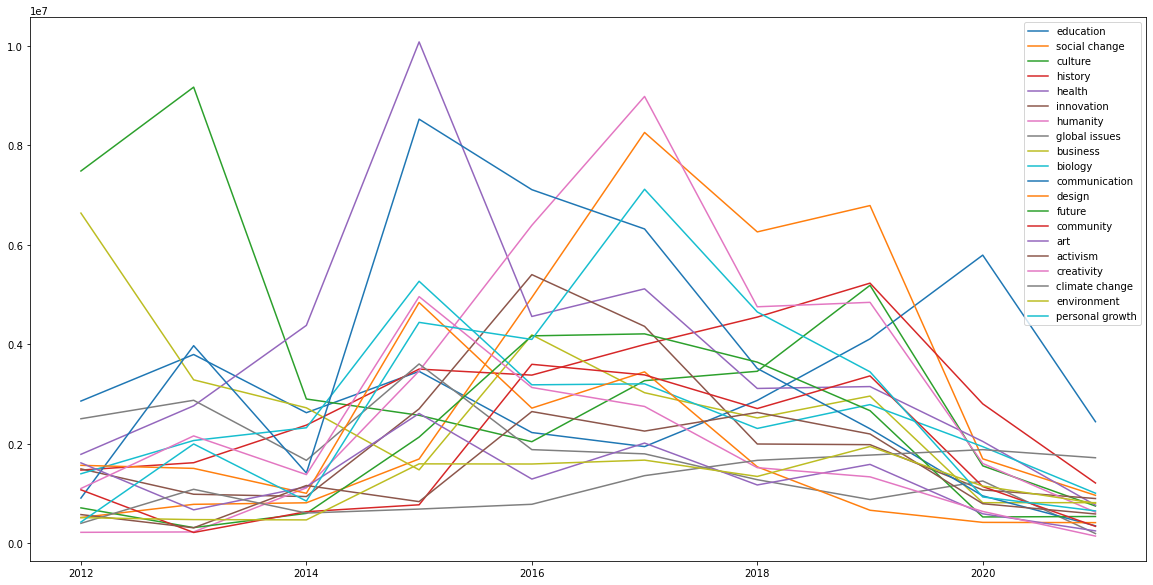

In [23]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

x = [i for i in range(2012, 2022)]
for topic in likes:
    plt.plot(x, list(likes[topic]), label = topic)

plt.legend()
plt.show()

# Среднее количество просмотров, лайков на одном видео в теме за 10 лет

### Количество просмотров

In [ ]:
average_view = dict()
for topic in views:
    average_view[topic] = sum(views[topic]) / sum(videos[topic])
    
x, y = [], []
for topic in average_view:
    x.append(topic)
    y.append(average_view[topic])

    
fig, ax = plt.subplots()
fig.set_figwidth(20)
ax.bar(x, y)
plt.show()

### Количество лайков

<Figure size 1440x720 with 0 Axes>

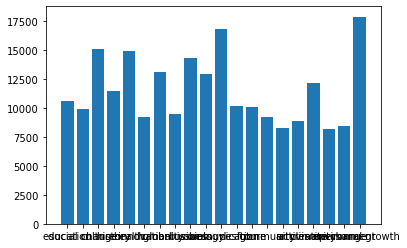

In [27]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

average_likes = dict()
for topic in views:
    average_likes[topic] = sum(likes[topic]) / sum(videos[topic])
    
x, y = [], []
for topic in average_likes:
    x.append(topic)
    y.append(average_likes[topic])

    

fig, ax = plt.subplots()
ax.bar(x, y)
plt.xticks(rotation=90)
plt.show()

# Количество видео, просмотров, лайков для каждой темы за 10 лет

### Количество видео

<Figure size 1440x720 with 0 Axes>

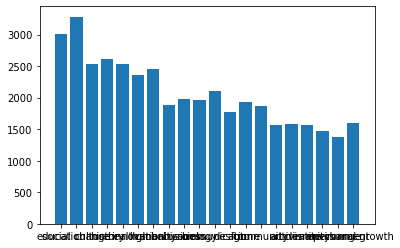

In [30]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

sum_videos = dict()
for topic in views:
    sum_videos[topic] = sum(videos[topic])
    
x, y = [], []
for topic in sum_videos:
    x.append(topic)
    y.append(sum_videos[topic])

    
fig, ax = plt.subplots()
ax.bar(x, y)
plt.show()

### Количество просмотров

<Figure size 1440x720 with 0 Axes>

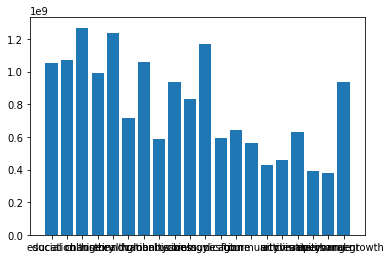

In [31]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

sum_views = dict()
for topic in views:
    sum_views[topic] = sum(views[topic])
    
x, y = [], []
for topic in sum_videos:
    x.append(topic)
    y.append(sum_views[topic])

    
fig, ax = plt.subplots()
ax.bar(x, y)
plt.show()

### Количество лайков

<Figure size 1440x720 with 0 Axes>

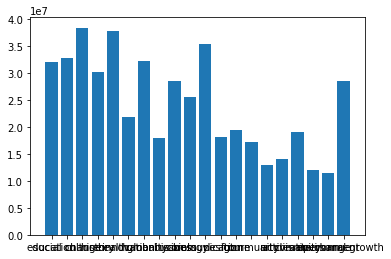

In [32]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

sum_likes = dict()
for topic in views:
    sum_likes[topic] = sum(likes[topic])
    
x, y = [], []
for topic in sum_likes:
    x.append(topic)
    y.append(sum_likes[topic])

    
fig, ax = plt.subplots()
ax.bar(x, y)
plt.show()

# Количество видео, просмотров, лайков STS по годам

In [33]:
sts = ['science', 'technology', 'society']
videos, views, likes = get_data(sts)

### Количество видео

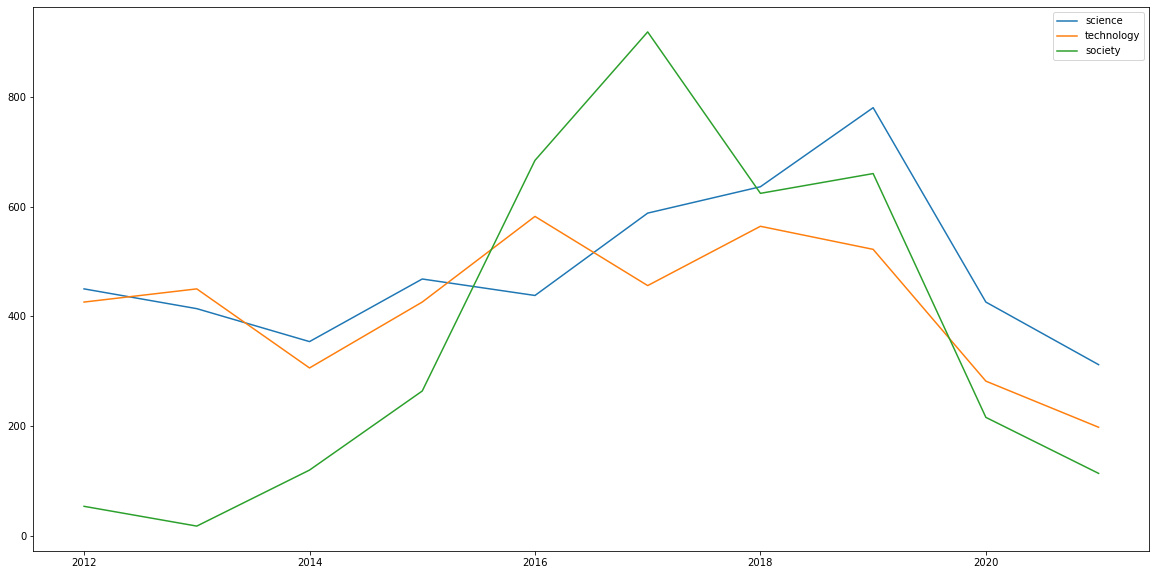

In [34]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

x = [i for i in range(2012, 2022)]
for topic in videos:
    plt.plot(x, list(videos[topic]), label = topic)

plt.legend()
plt.show()

### Количество просмотров

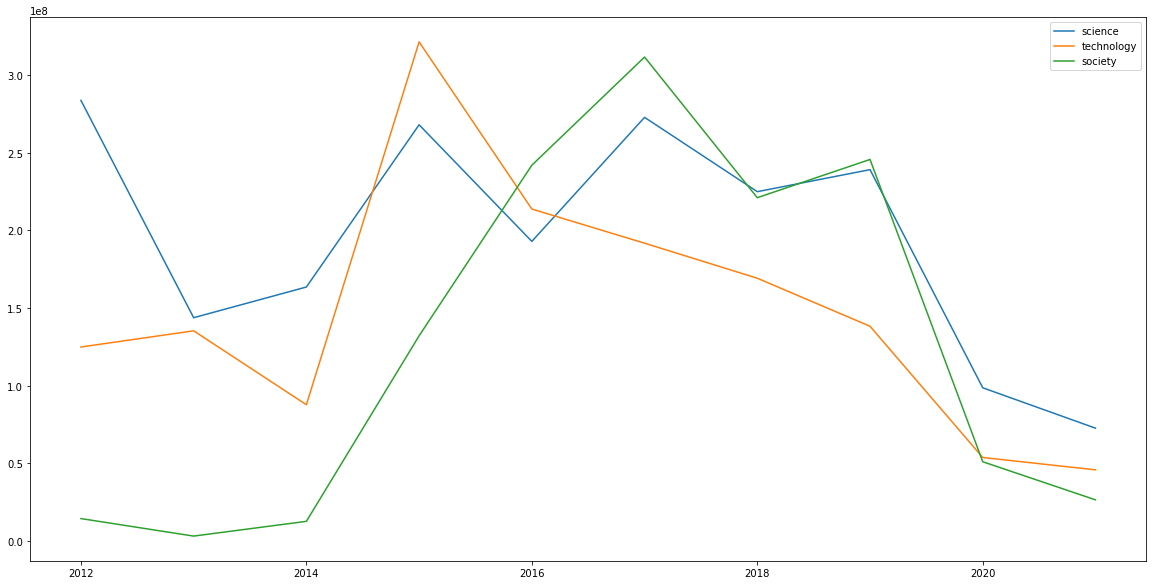

In [35]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

x = [i for i in range(2012, 2022)]
for topic in views:
    plt.plot(x, list(views[topic]), label = topic)

plt.legend()
plt.show()

### Количество лайков

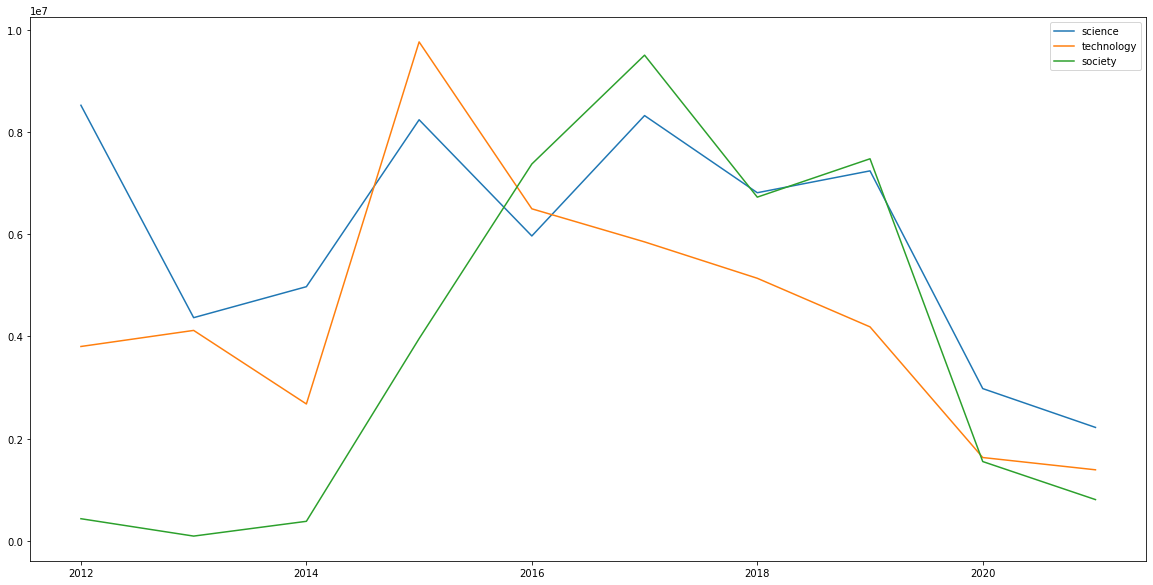

In [36]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

x = [i for i in range(2012, 2022)]
for topic in likes:
    plt.plot(x, list(likes[topic]), label = topic)

plt.legend()
plt.show()

# Самые популярные слова в каждой теме за 10 лет (20*1)

# Самые популярные слова в каждой теме по годам (20*10)

# Самые популярные слова за все темы по годам (10*1)

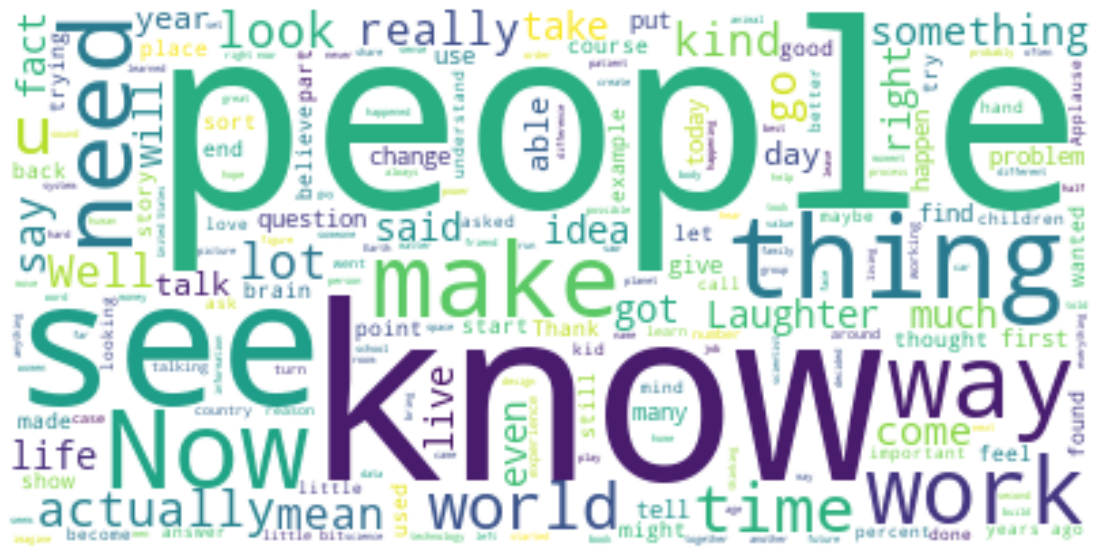

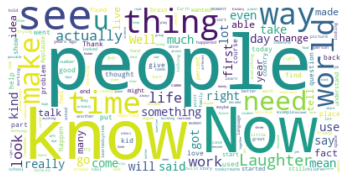

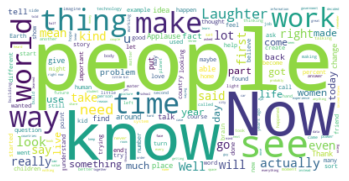

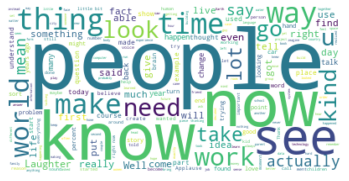

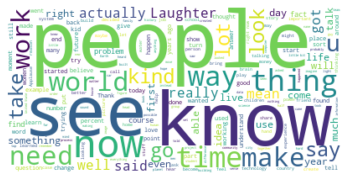

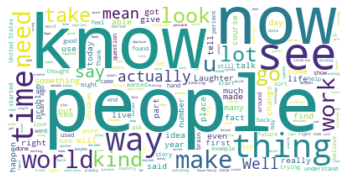

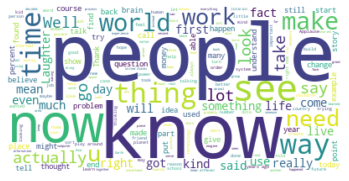

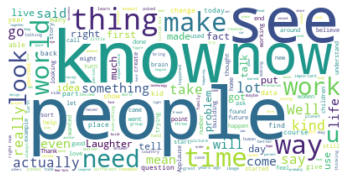

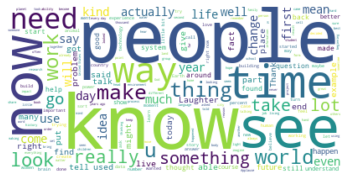

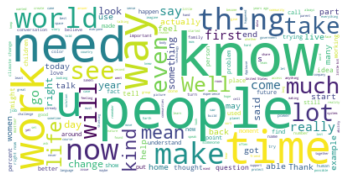

In [38]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

stopwords = set(STOPWORDS)
stopwords.update(["want", "minutes", "two", "think", "going", 'one'])

for year in range(2012, 2022):
    d = dataframe.loc[dataframe["Date"] == year]
    text = ""
    for row in d.itertuples(index=False):
        text = text + " ".join(review for review in str((row._asdict())['Transcript']).split()) 

    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Самые значимые слова за каждый год

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

dataframe = pd.read_csv("dataset_to_work.csv")
dataframe = dataframe.dropna()

X, y = dataframe['Transcript'], dataframe['Topic']
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X)    

grid = {'C': np.power(10.0, np.arange (-5, 6))}
cv = KFold(n_splits=5, random_state=241, shuffle=True)
clf = SVC(kernel='linear', random_state =241)
gs = GridSearchCV(clf, grid, scoring='accuracy' , cv=cv)
gs.fit(vectorizer.transform(X), y)

data = pd.DataFrame.from_dict(gs.cv_results_)
data.head(10)

mean_test_score_best = data.loc[:, 'mean_test_score'].max()
print(mean_test_score_best)

C = data.loc[data['mean_test_score'] == mean_test_score_best].loc[:, 'param_C'].min()
print(C)

model = SVC(kernel='linear', random_state=241, C=C)
model.fit(vectorizer.transform(X), y)

important_words = (pd.DataFrame.from_dict({'weight': np.absolute(model.coef_.toarray()[0]),
                                          'word':vectorizer.get_feature_names_out()
                                          })).sort_values(['weight'], ascending = False)

important_words.head(10)

# Самые значимые слова для каждой темы за все время

In [40]:
X, y = dataframe['Transcript'], dataframe['Date']
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X)    

grid = {'C': np.power(10.0, np.arange (-5, 6))}
cv = KFold(n_splits=5, random_state=241, shuffle=True)
clf = SVC(kernel='linear', random_state =241)
gs = GridSearchCV(clf, grid, scoring='accuracy' , cv=cv)
gs.fit(vectorizer.transform(X), y)

data = pd.DataFrame.from_dict(gs.cv_results_)
data.head(10)

mean_test_score_best = data.loc[:, 'mean_test_score'].max()
print(mean_test_score_best)

C = data.loc[data['mean_test_score'] == mean_test_score_best].loc[:, 'param_C'].min()
print(C)

model = SVC(kernel='linear', random_state=241, C=C)
model.fit(vectorizer.transform(X), y)

important_words = (pd.DataFrame.from_dict({'weight': np.absolute(model.coef_.toarray()[0]),
                                          'word':vectorizer.get_feature_names_out()
                                          })).sort_values(['weight'], ascending = False)

important_words.head(10)

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

ModuleNotFoundError: No module named 'tensorflow.python.platform'

In [ ]:
pip install tensorflow

     |████████████████████████████████| 497.6 MB 4.6 kB/s eta 0:00:01    |█████▉                          | 90.6 MB 5.6 MB/s eta 0:01:13
     |████████████████████████████████| 57 kB 2.6 MB/s eta 0:00:011
     |████████████████████████████████| 126 kB 87 kB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 934 kB/s eta 0:00:01
     |████████████████████████████████| 462 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 3.1 MB/s eta 0:00:01    |████████████████████▋           | 9.3 MB 2.0 MB/s eta 0:00:03
     |████████████████████████████████| 4.3 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 669 kB/s eta 0:00:011
     |████████████████████████████████| 781 kB 5.2